# NYC Housing Price Prediction - Feature Engineering

Simplified feature engineering pipeline using only selected features:
- `brokertitle`, `type`, `beds`, `bath`, `propertysqft`, `sublocality`, `price`

Models evaluated:
- Linear Regression
- Decision Tree Regressor
- Random Forest Regressor  
- XGBoost Regressor

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add shared module to path for FrequencyEncoder
import sys
import os
sys.path.append('../shared')

# Scikit-learn imports
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, cross_val_score, validation_curve, GridSearchCV, StratifiedKFold)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# Set style
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Loading and Feature Selection

In [26]:
# Define the selected features
model_features = ['BROKERTITLE', 'TYPE', 'BEDS', 'BATH', 'PROPERTYSQFT', 'SUBLOCALITY', 'PRICE']

# Load original dataset with selected features only
df_full = pd.read_csv('../data/raw/NY-House-Dataset.csv', usecols=model_features)

# Standardize column names to lowercase
df_full.columns = [col.lower() for col in df_full.columns]

print(f"Dataset shape: {df_full.shape}")
print(f"Selected features: {list(df_full.columns)}")
print("\n=== Dataset Info ===")
print(df_full.info())
print("\n=== Missing Values ===")
print(df_full.isnull().sum())

Dataset shape: (4801, 7)
Selected features: ['brokertitle', 'type', 'price', 'beds', 'bath', 'propertysqft', 'sublocality']

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brokertitle   4801 non-null   object 
 1   type          4801 non-null   object 
 2   price         4801 non-null   int64  
 3   beds          4801 non-null   int64  
 4   bath          4801 non-null   float64
 5   propertysqft  4801 non-null   float64
 6   sublocality   4801 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 262.7+ KB
None

=== Missing Values ===
brokertitle     0
type            0
price           0
beds            0
bath            0
propertysqft    0
sublocality     0
dtype: int64


In [27]:
# Data cleaning and preprocessing
print("=== Data Cleaning ===")

# Remove rows with missing values
print(f"Before cleaning: {len(df_full)} rows")
df_clean = df_full.dropna()
print(f"After removing NaN: {len(df_clean)} rows")

# Remove price outliers (keep prices between 1st and 99th percentile)
price_q01 = df_clean['price'].quantile(0.01)
price_q99 = df_clean['price'].quantile(0.99)
df_clean = df_clean[(df_clean['price'] >= price_q01) & (df_clean['price'] <= price_q99)]
print(f"After price filtering: {len(df_clean)} rows")

# Remove property size outliers
sqft_q01 = df_clean['propertysqft'].quantile(0.01)
sqft_q99 = df_clean['propertysqft'].quantile(0.99)
df_clean = df_clean[(df_clean['propertysqft'] >= sqft_q01) & (df_clean['propertysqft'] <= sqft_q99)]
print(f"After property size filtering: {len(df_clean)} rows")

print(f"\nFinal dataset shape: {df_clean.shape}")

=== Data Cleaning ===
Before cleaning: 4801 rows
After removing NaN: 4801 rows
After price filtering: 4706 rows
After property size filtering: 4610 rows

Final dataset shape: (4610, 7)


## 2. Exploratory Data Analysis

=== Price Distribution Analysis ===
count    4.610000e+03
mean     1.520558e+06
std      2.307569e+06
min      1.350000e+05
25%      4.996000e+05
50%      8.250000e+05
75%      1.445750e+06
max      2.250000e+07
Name: price, dtype: float64
Price skewness: 4.312

Log-price skewness: 0.703


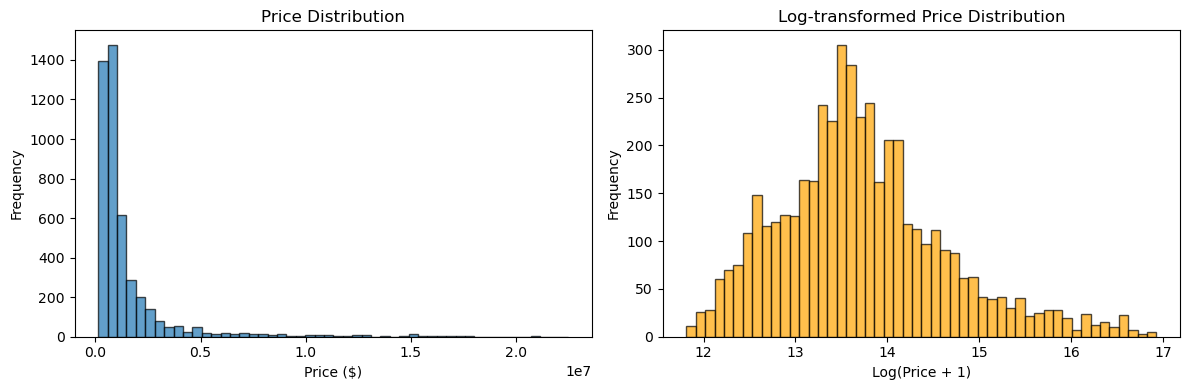

In [28]:
# Analyze target variable
print("=== Price Distribution Analysis ===")
print(df_clean['price'].describe())
print(f"Price skewness: {df_clean['price'].skew():.3f}")

# Visualize price distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original price distribution
axes[0].hist(df_clean['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Price Distribution')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

# Log-transformed price distribution
log_price = np.log1p(df_clean['price'])
axes[1].hist(log_price, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Log-transformed Price Distribution')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')

print(f"\nLog-price skewness: {log_price.skew():.3f}")
plt.tight_layout()
plt.show()

In [29]:
# Analyze categorical features
categorical_features = ['brokertitle', 'type', 'sublocality']
numerical_features = ['beds', 'bath', 'propertysqft']

print("=== Categorical Features Analysis ===")
for col in categorical_features:
    unique_count = df_clean[col].nunique()
    print(f"\n{col.upper()}: {unique_count} unique values")
    if unique_count <= 20:
        print("Top values:")
        print(df_clean[col].value_counts().head(10))
    else:
        print("Top 10 values:")
        print(df_clean[col].value_counts().head(10))
        print(f"Note: This is a high cardinality feature ({unique_count} values)")

=== Categorical Features Analysis ===

BROKERTITLE: 1010 unique values
Top 10 values:
brokertitle
Brokered by COMPASS                                                           437
Brokered by Douglas Elliman - 575 Madison Ave                                  95
Brokered by Brown Harris Stevens                                               91
Brokered by Corcoran East Side                                                 85
Brokered by RE MAX Edge                                                        77
Brokered by Winzone Realty Inc                                                 68
Brokered by E Realty International Corp                                        59
Brokered by Sotheby's International Realty - East Side Manhattan Brokerage     58
Brokered by RE MAX Real Estate Professionals                                   51
Brokered by Serhant                                                            49
Name: count, dtype: int64
Note: This is a high cardinality feature (1010 values)



=== Numerical Features Analysis ===
              beds         bath  propertysqft
count  4610.000000  4610.000000   4610.000000
mean      3.261822     2.285509   2005.521240
std       2.175974     1.419242   1069.338272
min       1.000000     0.000000    485.000000
25%       2.000000     1.000000   1214.250000
50%       3.000000     2.000000   2184.207862
75%       4.000000     3.000000   2184.207862
max      32.000000    12.000000   8049.000000

=== Correlation with Price ===
price           1.000000
propertysqft    0.484348
bath            0.446307
beds            0.251809
Name: price, dtype: float64


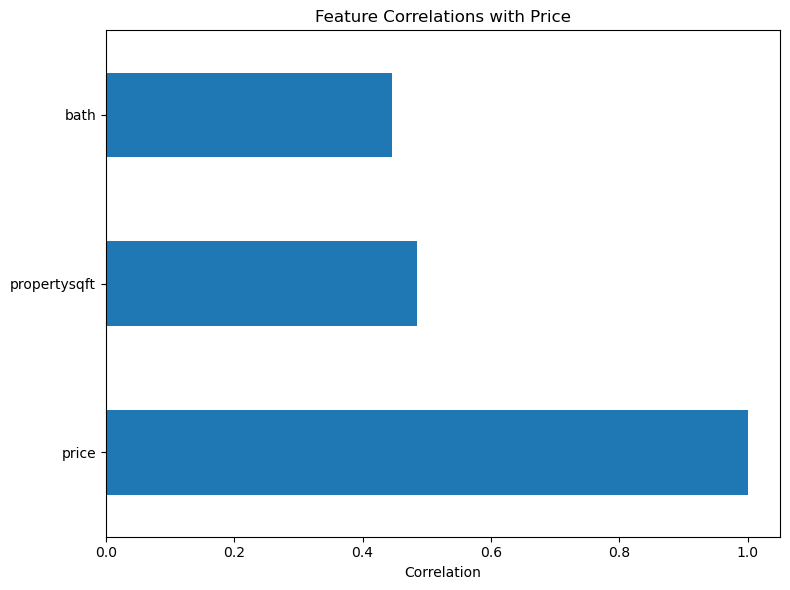

In [30]:
# Analyze numerical features
print("=== Numerical Features Analysis ===")
print(df_clean[numerical_features].describe())

# Correlation with target
print("\n=== Correlation with Price ===")
correlations = df_clean[numerical_features + ['price']].corr()['price'].sort_values(ascending=False)
print(correlations)

# Visualize correlations
plt.figure(figsize=(8, 6))
correlations[:-1].plot(kind='barh')
plt.title('Feature Correlations with Price')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## 3. FrequencyEncoder Implementation

In [47]:
# Import FrequencyEncoder from shared module
try:
    from utils import FrequencyEncoder
    print("FrequencyEncoder imported from shared module successfully!")
except ImportError:
    print("Could not import FrequencyEncoder from shared module, using local implementation...")
    
    # Fallback: Local FrequencyEncoder implementation
    from sklearn.base import BaseEstimator, TransformerMixin

    class FrequencyEncoder(BaseEstimator, TransformerMixin):
        """
        Custom frequency encoder for categorical features using scikit-learn interface.
        Replaces categorical values with their frequency of occurrence in the training data.
        """
        
        def __init__(self, handle_unknown='zero'):
            """
            Parameters:
            - handle_unknown: how to handle unknown categories during transform
              'zero': assign frequency 0
              'rare': assign frequency 1
            """
            self.handle_unknown = handle_unknown
            self.frequency_maps_ = {}
            self.feature_names_in_ = None
            
        def fit(self, X, y=None):
            """Fit the frequency encoder by computing frequencies for each column."""
            import pandas as pd
            
            # Convert to DataFrame if numpy array
            if hasattr(X, 'columns'):
                df = X
                self.feature_names_in_ = list(X.columns)
            else:
                df = pd.DataFrame(X)
                self.feature_names_in_ = [f'feature_{i}' for i in range(X.shape[1])]
            
            # Compute frequency maps for each column
            for col in df.columns:
                value_counts = df[col].value_counts()
                self.frequency_maps_[col] = value_counts.to_dict()
                
            return self
        
        def transform(self, X):
            """Transform categorical values to their frequencies."""
            import pandas as pd
            import numpy as np
            
            # Convert to DataFrame if numpy array
            if hasattr(X, 'columns'):
                df = X.copy()
            else:
                df = pd.DataFrame(X, columns=self.feature_names_in_)
            
            # Transform each column
            for col in df.columns:
                if col in self.frequency_maps_:
                    # Map values to frequencies
                    frequency_map = self.frequency_maps_[col]
                    
                    if self.handle_unknown == 'zero':
                        # Unknown categories get frequency 0
                        df[col] = df[col].map(frequency_map).fillna(0)
                    else:  # handle_unknown == 'rare'
                        # Unknown categories get frequency 1 (treated as rare)
                        df[col] = df[col].map(frequency_map).fillna(1)
            
            return df.values
        
        def get_feature_names_out(self, input_features=None):
            """Get output feature names."""
            if input_features is None:
                return np.array(self.feature_names_in_)
            return np.array(input_features)

    print("Local FrequencyEncoder class created successfully!")

FrequencyEncoder imported from shared module successfully!


## 4. Data Splitting

In [ ]:
# Prepare features and target
target_col = 'price'
feature_cols = [col for col in df_clean.columns if col != target_col]
rs = 42  # Random state for reproducibility



# Split with stratify strategy by price quantiles to preserve price distribution.
# Fall back to TYPE (categorical) if qcut produces only a single bin or fails.
stratify_series = None
try:
    price_bins = pd.qcut(df_clean["price"], q=10, duplicates="drop")
    if price_bins.nunique() > 1:
        stratify_series = price_bins
except Exception:
    print("qcut stratification failed, falling back to TYPE if possible.")
    stratify_series = None

if stratify_series is None and "type" in df_clean.columns and df_clean["type"].nunique() > 1:
    stratify_series = df_clean["type"]

# First split: train (80%) and temp (20% -> val+test)
try:
    train_df, temp_df = train_test_split(
        df_clean,
        test_size=0.2,
        random_state=rs,
        stratify=(stratify_series if stratify_series is None else stratify_series)
    )
except ValueError:
    # If stratification fails (e.g. too few samples per class), split without stratify
    print("Stratified split failed, performing unstratified split.")
    train_df, temp_df = train_test_split(df_clean, test_size=0.2, random_state=rs, stratify=None)

# Second split: val and test (each 10% of original -> 50% of temp)
# If using a stratify_series, align it to temp_df indices
stratify_temp = None
if stratify_series is not None:
    stratify_temp = stratify_series.loc[temp_df.index]

try:
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.5,
        random_state=rs,
        stratify=stratify_temp
    )
except ValueError:
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=rs, stratify=None)
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_val = val_df[feature_cols]
y_val = val_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Features: {feature_cols}")
print(f"Target: {target_col}")
print(f"Dataset shape: X{df_clean.shape}, y{df_clean[target_col].shape}")

print(f"\nTrain set: X{X_train.shape}, y{y_train.shape}")
print(f"Validation set: X{X_val.shape}, y{y_val.shape}")
print(f"Test set: X{X_test.shape}, y{y_test.shape}")
print(f"Split ratios: {len(X_train)/len(df_clean):.1%} train, {len(X_val)/len(df_clean):.1%} val, {len(X_test)/len(df_clean):.1%} test")

# For later use, define X and y for the full cleaned dataset, No stratified split performed here

# X = df_clean[feature_cols]
# y = df_clean[target_col]

# # Split data into train, validation, and test sets
# # First split: 80% train+val, 20% test
# X_temp, X_test, y_temp, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=None
# )

# # Second split: 75% train, 25% val (from the 80%)
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.25, random_state=42, stratify=None
# )
# X = df_clean[feature_cols]
# y = df_clean[target_col]

# print(f"Features: {feature_cols}")
# print(f"Target: {target_col}")
# print(f"Dataset shape: X{X.shape}, y{y.shape}")

# print(f"\nTrain set: X{X_train.shape}, y{y_train.shape}")
# print(f"Validation set: X{X_val.shape}, y{y_val.shape}")
# print(f"Test set: X{X_test.shape}, y{y_test.shape}")
# print(f"Split ratios: {len(X_train)/len(X):.1%} train, {len(X_val)/len(X):.1%} val, {len(X_test)/len(X):.1%} test")

Features: ['brokertitle', 'type', 'beds', 'bath', 'propertysqft', 'sublocality']
Target: price
Dataset shape: X(4610, 7), y(4610,)

Train set: X(3688, 6), y(3688,)
Validation set: X(461, 6), y(461,)
Test set: X(461, 6), y(461,)
Split ratios: 80.0% train, 10.0% val, 10.0% test


## 5. Preprocessing Pipeline Creation

In [33]:
def create_preprocessor(categorical_encoding='onehot', scaling_method='standard'):
    """
    Create a preprocessing pipeline
    
    Parameters:
    - categorical_encoding: 'onehot' or 'frequency'
    - scaling_method: 'standard', 'minmax', 'robust', or 'none'
    """
    
    # Separate high and low cardinality features
    high_cardinality_threshold = 50
    
    high_cardinality_features = []
    low_cardinality_features = []
    
    for col in categorical_features:
        unique_count = X_train[col].nunique()
        if unique_count > high_cardinality_threshold:
            high_cardinality_features.append(col)
        else:
            low_cardinality_features.append(col)
    
    print(f"Low cardinality features: {low_cardinality_features}")
    print(f"High cardinality features: {high_cardinality_features}")
    
    # Create transformers list
    transformers = []
    
    # Handle categorical features
    if categorical_encoding == 'frequency':
        # Use frequency encoding for high cardinality
        if high_cardinality_features:
            freq_encoder = FrequencyEncoder(handle_unknown='zero')
            transformers.append(('categorical_high', freq_encoder, high_cardinality_features))
        
        # Use OneHot for low cardinality
        if low_cardinality_features:
            onehot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
            transformers.append(('categorical_low', onehot_encoder, low_cardinality_features))
    else:
        # Use OneHot for all categorical features
        if categorical_features:
            onehot_encoder = OneHotEncoder(
                drop='first', 
                handle_unknown='ignore',
                max_categories=20 if high_cardinality_features else None
            )
            transformers.append(('categorical', onehot_encoder, categorical_features))
    
    # Handle numerical features
    if scaling_method == 'standard':
        numerical_preprocessor = StandardScaler()
    elif scaling_method == 'minmax':
        numerical_preprocessor = MinMaxScaler()
    elif scaling_method == 'robust':
        numerical_preprocessor = RobustScaler()
    else:  # 'none'
        numerical_preprocessor = 'passthrough'
    
    # Add numerical preprocessing
    transformers.append(('numerical', numerical_preprocessor, numerical_features))
    
    # Create column transformer
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )
    
    return preprocessor

# Test the preprocessor creation
test_preprocessor = create_preprocessor()
print("\nPreprocessor created successfully!")

Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']

Preprocessor created successfully!


## 6. Hyperparameter Tuning for Ensemble Methods

In [34]:
# Target transformation for tuning
use_log_target = True

if use_log_target:
    y_train_transformed = np.log1p(y_train)
    y_val_transformed = np.log1p(y_val)
    print("Using log-transformed target for training")
else:
    y_train_transformed = y_train
    y_val_transformed = y_val
    print("Using original target scale")

# Define range of n_estimators to test
n_estimators_range = [3, 5, 10, 12, 15, 20, 22, 25, 27, 30, 50, 60, 70, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

print(f"\nTesting n_estimators values: {n_estimators_range}")
print(f"Training set: X{X_train.shape}, y{y_train_transformed.shape}")
print(f"Validation set: X{X_val.shape}, y{y_val_transformed.shape}")

Using log-transformed target for training

Testing n_estimators values: [3, 5, 10, 12, 15, 20, 22, 25, 27, 30, 50, 60, 70, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
Training set: X(3688, 6), y(3688,)
Validation set: X(461, 6), y(461,)


In [35]:
# Tune RandomForest n_estimators
print("=== Tuning RandomForest n_estimators ===")

# Create base RandomForest pipeline
rf_base_preprocessor = create_preprocessor(
    categorical_encoding='onehot',
    scaling_method='none'
)

# Test validation curve for RandomForest
rf_train_scores, rf_val_scores = validation_curve(
    Pipeline([
        ('preprocessor', rf_base_preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
    ]),
    X_train, y_train_transformed,
    param_name='regressor__n_estimators',
    param_range=n_estimators_range,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Calculate mean and std for plotting
rf_train_mean = rf_train_scores.mean(axis=1)
rf_train_std = rf_train_scores.std(axis=1)
rf_val_mean = rf_val_scores.mean(axis=1)
rf_val_std = rf_val_scores.std(axis=1)

# Find best n_estimators for RandomForest
best_rf_idx = np.argmax(rf_val_mean)
best_rf_n_estimators = n_estimators_range[best_rf_idx]
best_rf_score = rf_val_mean[best_rf_idx]

print(f"Best RandomForest n_estimators: {best_rf_n_estimators}")
print(f"Best RandomForest CV R²: {best_rf_score:.4f}")
print()

# Display all results
print("RandomForest Results:")
for i, n_est in enumerate(n_estimators_range):
    print(f"  n_estimators={n_est}: CV R² = {rf_val_mean[i]:.4f} (+/- {rf_val_std[i]*2:.4f})")
print()

=== Tuning RandomForest n_estimators ===
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']
Best RandomForest n_estimators: 200
Best RandomForest CV R²: 0.7298

RandomForest Results:
  n_estimators=3: CV R² = 0.6832 (+/- 0.0278)
  n_estimators=5: CV R² = 0.7035 (+/- 0.0279)
  n_estimators=10: CV R² = 0.7174 (+/- 0.0222)
  n_estimators=12: CV R² = 0.7207 (+/- 0.0209)
  n_estimators=15: CV R² = 0.7221 (+/- 0.0208)
  n_estimators=20: CV R² = 0.7232 (+/- 0.0252)
  n_estimators=22: CV R² = 0.7243 (+/- 0.0259)
  n_estimators=25: CV R² = 0.7260 (+/- 0.0232)
  n_estimators=27: CV R² = 0.7255 (+/- 0.0217)
  n_estimators=30: CV R² = 0.7257 (+/- 0.0214)
  n_estimators=50: CV R² = 0.7268 (+/- 0.0221)
  n_estimators=60: CV R² = 0.7276 (+/- 0.0220)
  n_estimators=70: CV R² = 0.7275 (+/- 0.0225)
  n_estimators=100: CV R² = 0.7290 (+/- 0.0237)
  n_estimators=110: CV R² = 0.7290 (+/- 0.0238)
  n_estimators=120: CV R² = 0.7291 (+/- 0.0244)
  n_estimators=130: CV

In [36]:
# Tune XGBoost n_estimators
print("=== Tuning XGBoost n_estimators ===")

# Create base XGBoost pipeline
xgb_base_preprocessor = create_preprocessor(
    categorical_encoding='onehot',
    scaling_method='standard'
)

# Test validation curve for XGBoost
xgb_train_scores, xgb_val_scores = validation_curve(
    Pipeline([
        ('preprocessor', xgb_base_preprocessor),
        ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
    ]),
    X_train, y_train_transformed,
    param_name='regressor__n_estimators',
    param_range=n_estimators_range,
    cv=5,  # Use 3-fold CV for speed
    scoring='r2',
    n_jobs=-1
)

# Calculate mean and std for plotting
xgb_train_mean = xgb_train_scores.mean(axis=1)
xgb_train_std = xgb_train_scores.std(axis=1)
xgb_val_mean = xgb_val_scores.mean(axis=1)
xgb_val_std = xgb_val_scores.std(axis=1)

# Find best n_estimators for XGBoost
best_xgb_idx = np.argmax(xgb_val_mean)
best_xgb_n_estimators = n_estimators_range[best_xgb_idx]
best_xgb_score = xgb_val_mean[best_xgb_idx]

print(f"Best XGBoost n_estimators: {best_xgb_n_estimators}")
print(f"Best XGBoost CV R²: {best_xgb_score:.4f}")
print()

# Display all results
print("XGBoost Results:")
for i, n_est in enumerate(n_estimators_range):
    print(f"  n_estimators={n_est}: CV R² = {xgb_val_mean[i]:.4f} (+/- {xgb_val_std[i]*2:.4f})")
print()

=== Tuning XGBoost n_estimators ===
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']
Best XGBoost n_estimators: 50
Best XGBoost CV R²: 0.7413

XGBoost Results:
  n_estimators=3: CV R² = 0.6106 (+/- 0.0281)
  n_estimators=5: CV R² = 0.6939 (+/- 0.0216)
  n_estimators=10: CV R² = 0.7319 (+/- 0.0204)
  n_estimators=12: CV R² = 0.7359 (+/- 0.0213)
  n_estimators=15: CV R² = 0.7376 (+/- 0.0226)
  n_estimators=20: CV R² = 0.7387 (+/- 0.0222)
  n_estimators=22: CV R² = 0.7391 (+/- 0.0223)
  n_estimators=25: CV R² = 0.7401 (+/- 0.0226)
  n_estimators=27: CV R² = 0.7404 (+/- 0.0220)
  n_estimators=30: CV R² = 0.7412 (+/- 0.0209)
  n_estimators=50: CV R² = 0.7413 (+/- 0.0236)
  n_estimators=60: CV R² = 0.7397 (+/- 0.0227)
  n_estimators=70: CV R² = 0.7385 (+/- 0.0214)
  n_estimators=100: CV R² = 0.7323 (+/- 0.0258)
  n_estimators=110: CV R² = 0.7302 (+/- 0.0255)
  n_estimators=120: CV R² = 0.7296 (+/- 0.0252)
  n_estimators=130: CV R² = 0.7290 (+/- 0.0

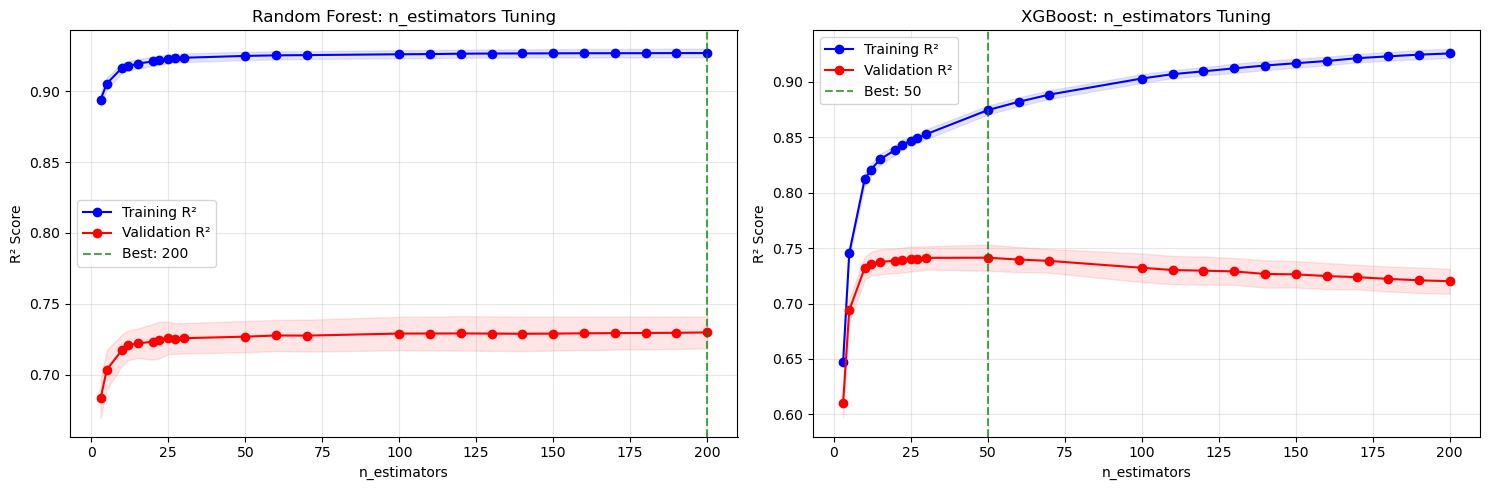

=== Hyperparameter Tuning Summary ===
Random Forest optimal n_estimators: 200 (R² = 0.7298)
XGBoost optimal n_estimators: 50 (R² = 0.7413)



In [37]:
# Visualize hyperparameter tuning results
plt.figure(figsize=(15, 5))

# Random Forest validation curve
plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, rf_train_mean, 'o-', color='blue', label='Training R²')
plt.fill_between(n_estimators_range, rf_train_mean - rf_train_std, 
                 rf_train_mean + rf_train_std, alpha=0.1, color='blue')
plt.plot(n_estimators_range, rf_val_mean, 'o-', color='red', label='Validation R²')
plt.fill_between(n_estimators_range, rf_val_mean - rf_val_std, 
                 rf_val_mean + rf_val_std, alpha=0.1, color='red')
plt.axvline(x=best_rf_n_estimators, color='green', linestyle='--', alpha=0.7, 
            label=f'Best: {best_rf_n_estimators}')
plt.xlabel('n_estimators')
plt.ylabel('R² Score')
plt.title('Random Forest: n_estimators Tuning')
plt.legend()
plt.grid(True, alpha=0.3)

# XGBoost validation curve
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, xgb_train_mean, 'o-', color='blue', label='Training R²')
plt.fill_between(n_estimators_range, xgb_train_mean - xgb_train_std, 
                 xgb_train_mean + xgb_train_std, alpha=0.1, color='blue')
plt.plot(n_estimators_range, xgb_val_mean, 'o-', color='red', label='Validation R²')
plt.fill_between(n_estimators_range, xgb_val_mean - xgb_val_std, 
                 xgb_val_mean + xgb_val_std, alpha=0.1, color='red')
plt.axvline(x=best_xgb_n_estimators, color='green', linestyle='--', alpha=0.7, 
            label=f'Best: {best_xgb_n_estimators}')
plt.xlabel('n_estimators')
plt.ylabel('R² Score')
plt.title('XGBoost: n_estimators Tuning')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("=== Hyperparameter Tuning Summary ===")
print(f"Random Forest optimal n_estimators: {best_rf_n_estimators} (R² = {best_rf_score:.4f})")
print(f"XGBoost optimal n_estimators: {best_xgb_n_estimators} (R² = {best_xgb_score:.4f})")
print()

## 7. Model Pipeline Creation with Tuned Hyperparameters

In [38]:
# Create model-specific pipelines with optimized hyperparameters

print("Creating optimized model pipelines...")

# Create reusable preprocessors to avoid redundant calls
print("Setting up preprocessors...")
linear_preprocessor = create_preprocessor(categorical_encoding='onehot', scaling_method='standard')
tree_preprocessor = create_preprocessor(categorical_encoding='onehot', scaling_method='none') 
rf_freq_preprocessor = create_preprocessor(categorical_encoding='frequency', scaling_method='none')
xgb_preprocessor = create_preprocessor(categorical_encoding='onehot', scaling_method='standard')
xgb_freq_preprocessor = create_preprocessor(categorical_encoding='frequency', scaling_method='standard')

# Linear Regression - needs scaling
linear_pipeline = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('regressor', LinearRegression())
])

# Decision Tree - doesn't need scaling
tree_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Random Forest - use tuned n_estimators, no scaling needed
rf_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),  # Reuse tree_preprocessor (same config)
    ('regressor', RandomForestRegressor(
        n_estimators=best_rf_n_estimators,
        random_state=42, 
        n_jobs=-1
    ))
])

# Random Forest with frequency encoding
rf_freq_pipeline = Pipeline([
    ('preprocessor', rf_freq_preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=best_rf_n_estimators,
        random_state=42, 
        n_jobs=-1
    ))
])

# XGBoost - use tuned n_estimators
xgb_pipeline = Pipeline([
    ('preprocessor', xgb_preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=best_xgb_n_estimators,
        random_state=42, 
        n_jobs=-1
    ))
])

# XGBoost with frequency encoding
xgb_freq_pipeline = Pipeline([
    ('preprocessor', xgb_freq_preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=best_xgb_n_estimators,
        random_state=42, 
        n_jobs=-1
    ))
])

# Store all pipelines
pipelines = {
    'Linear Regression': linear_pipeline,
    'Decision Tree': tree_pipeline,
    'Random Forest': rf_pipeline,
    'Random Forest (Freq)': rf_freq_pipeline,
    'XGBoost': xgb_pipeline,
    'XGBoost (Freq)': xgb_freq_pipeline
}

print(f"✅ Created {len(pipelines)} model pipelines successfully!")
print(f"Models to evaluate: {list(pipelines.keys())}")
print(f"\nUsing tuned hyperparameters:")
print(f"- Random Forest n_estimators: {best_rf_n_estimators}")
print(f"- XGBoost n_estimators: {best_xgb_n_estimators}")

Creating optimized model pipelines...
Setting up preprocessors...
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']
✅ Created 6 model pipelines successfully!
Models to evaluate: ['Linear Regression', 'Decision Tree', 'Random Forest', 'Random Forest (Freq)', 'XGBoost', 'XGBoost (Freq)']

Using tuned hyperparameters:
- Random Forest n_estimators: 200
- XGBoost n_estimators: 50


## 8. Model Training and Evaluation

In [39]:
# Train and evaluate all models
results = {}

print("=== Model Training and Evaluation ===")
print("Training models with cross-validation...\n")

for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    
    try:
        # Cross-validation on training set
        cv_scores = cross_val_score(
            pipeline, X_train, y_train_transformed, 
            cv=5, scoring='r2', n_jobs=-1
        )
        
        # Fit on full training set
        pipeline.fit(X_train, y_train_transformed)
        
        # Predictions on validation set
        y_pred = pipeline.predict(X_val)
        
        # Convert back to original scale if log-transformed
        if use_log_target:
            y_pred_original = np.expm1(y_pred)
            y_val_original = y_val
        else:
            y_pred_original = y_pred
            y_val_original = y_val
        
        # Calculate metrics on original scale
        rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
        mae = mean_absolute_error(y_val_original, y_pred_original)
        r2 = r2_score(y_val_original, y_pred_original)
        
        # Store results
        results[name] = {
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'val_r2': r2,
            'val_rmse': rmse,
            'val_mae': mae,
            'pipeline': pipeline
        }
        
        print(f"  CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"  Val R²: {r2:.4f}")
        print(f"  Val RMSE: ${rmse:,.0f}")
        print(f"  Val MAE: ${mae:,.0f}")
        print()
        
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        print()
        continue

=== Model Training and Evaluation ===
Training models with cross-validation...

Training Linear Regression...
  CV R²: 0.6518 (+/- 0.0530)
  Val R²: 0.1052
  Val RMSE: $2,166,982
  Val MAE: $749,069

Training Decision Tree...
  CV R²: 0.5989 (+/- 0.0349)
  Val R²: 0.3782
  Val RMSE: $1,806,417
  Val MAE: $696,401

Training Random Forest...
  CV R²: 0.7298 (+/- 0.0226)
  Val R²: 0.6724
  Val RMSE: $1,311,270
  Val MAE: $557,141

Training Random Forest (Freq)...
  CV R²: 0.7376 (+/- 0.0361)
  Val R²: 0.6910
  Val RMSE: $1,273,533
  Val MAE: $548,968

Training XGBoost...
  CV R²: 0.7413 (+/- 0.0236)
  Val R²: 0.6850
  Val RMSE: $1,285,836
  Val MAE: $564,121

Training XGBoost (Freq)...
  CV R²: 0.7322 (+/- 0.0382)
  Val R²: 0.7183
  Val RMSE: $1,215,863
  Val MAE: $527,658



In [40]:
# Create results comparison and identify best model
if results:
    results_df = pd.DataFrame({
        'Model': results.keys(),
        'CV_R2_Mean': [results[k]['cv_mean'] for k in results.keys()],
        'CV_R2_Std': [results[k]['cv_std'] for k in results.keys()],
        'Val_R2': [results[k]['val_r2'] for k in results.keys()],
        'Val_RMSE': [results[k]['val_rmse'] for k in results.keys()],
        'Val_MAE': [results[k]['val_mae'] for k in results.keys()]
    })
    
    # Sort by validation R²
    results_df = results_df.sort_values('Val_R2', ascending=False)
    
    print("=== Model Comparison Results ===")
    print(results_df.round(4))
    
    # Find best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = results[best_model_name]['pipeline']
    
    print(f"\nBest performing model: {best_model_name}")
    print(f"Validation R²: {results_df.iloc[0]['Val_R2']:.4f}")
else:
    print("No successful model training results to display.")
    best_model_name = None
    best_model = None

=== Model Comparison Results ===
                  Model  CV_R2_Mean  CV_R2_Std  Val_R2      Val_RMSE  \
5        XGBoost (Freq)      0.7322     0.0191  0.7183  1.215863e+06   
3  Random Forest (Freq)      0.7376     0.0181  0.6910  1.273533e+06   
4               XGBoost      0.7413     0.0118  0.6850  1.285836e+06   
2         Random Forest      0.7298     0.0113  0.6724  1.311270e+06   
1         Decision Tree      0.5989     0.0175  0.3782  1.806417e+06   
0     Linear Regression      0.6518     0.0265  0.1052  2.166982e+06   

       Val_MAE  
5  527658.4375  
3  548968.3831  
4  564121.4375  
2  557141.0157  
1  696401.3862  
0  749069.3804  

Best performing model: XGBoost (Freq)
Validation R²: 0.7183


In [41]:
# GridSearch Hyperparameter Optimization for Best Model
if best_model_name and results:
    print("=== GridSearch Optimization for Best Model ===")
    print(f"Optimizing: {best_model_name}")
    
    base_pipeline = None
    param_grid = None
    
    # Determine which model type to optimize
    if 'XGBoost' in best_model_name:
        model_type = 'xgboost'
        print("\nOptimizing XGBoost hyperparameters...")
        
        # XGBoost parameter grid
        param_grid = {
            'regressor__n_estimators': [best_xgb_n_estimators, best_xgb_n_estimators + 50, best_xgb_n_estimators + 100, best_xgb_n_estimators + 150, best_xgb_n_estimators + 200],
            'regressor__max_depth': [3, 4, 5, 10, 20],
            'regressor__learning_rate': [0.05, 0.1, 0.15, 0.2],
            'regressor__subsample': [0.6, 0.8, 1.0],
            'regressor__colsample_bytree': [0.6, 0.8, 1.0],
            'regressor__gamma': [0.5, 1, 1.5, 2, 5],
            'regressor__min_child_weight': [1, 5, 10],
        }

        # Create base pipeline for XGBoost
        if 'Freq' in best_model_name:
            base_preprocessor = create_preprocessor(
                categorical_encoding='frequency',
                scaling_method='standard'
            )
        else:
            base_preprocessor = create_preprocessor(
                categorical_encoding='onehot',
                scaling_method='standard'
            )
        
        base_pipeline = Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
        ])
        
    elif 'Random Forest' in best_model_name:
        model_type = 'random_forest'
        print("\nOptimizing Random Forest hyperparameters...")
        
        # Random Forest parameter grid - reduced for faster execution  
        param_grid = {
            'regressor__n_estimators': [best_rf_n_estimators, best_rf_n_estimators + 50, best_rf_n_estimators + 100, 
                    best_rf_n_estimators + 150, best_rf_n_estimators + 200, best_rf_n_estimators + 250],
            'regressor__max_depth': [10, 15, 20, 30, None],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4]
        }

        # Create base pipeline for Random Forest
        if 'Freq' in best_model_name:
            base_preprocessor = create_preprocessor(
                categorical_encoding='frequency',
                scaling_method='none'
            )
        else:
            base_preprocessor = create_preprocessor(
                categorical_encoding='onehot',
                scaling_method='none'
            )
        
        base_pipeline = Pipeline([
            ('preprocessor', base_preprocessor),
            ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
        ])
        
    else:
        model_type = 'other'
        print(f"\nGridSearch not implemented for {best_model_name}")
        print("Skipping GridSearch optimization")
    
    # Execute GridSearch if model type is supported
    if model_type in ['xgboost', 'random_forest']:
        total_combinations = 1
        for values in param_grid.values():
            total_combinations *= len(values)
        print(f"\nParameter combinations to test: {total_combinations}")
        print(f"With 5-fold CV: {total_combinations * 5} model fits")
        
        print(f"\n=== Running GridSearch Optimization ===")
        print("This may take a few minutes...")
        
        # Initialize and run GridSearchCV
        grid_search = GridSearchCV(
            estimator=base_pipeline,
            param_grid=param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        # Fit GridSearch on training data
        grid_search.fit(X_train, y_train_transformed)
        
        # Get results
        best_params = grid_search.best_params_
        best_grid_score = grid_search.best_score_
        best_grid_model = grid_search.best_estimator_
        
        print(f"\n=== GridSearch Results ===")
        print(f"Best CV Score (R²): {best_grid_score:.4f}")
        print(f"\nBest Parameters:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
        
        # Evaluate on validation set
        y_val_pred = best_grid_model.predict(X_val)
        if use_log_target:
            y_val_pred_original = np.expm1(y_val_pred)
            y_val_original = y_val
        else:
            y_val_pred_original = y_val_pred
            y_val_original = y_val
        
        # Calculate validation metrics
        grid_val_r2 = r2_score(y_val_original, y_val_pred_original)
        grid_val_rmse = np.sqrt(mean_squared_error(y_val_original, y_val_pred_original))
        
        print(f"\n=== Validation Performance ===")
        print(f"Optimized Model R²: {grid_val_r2:.4f}")
        print(f"Optimized Model RMSE: ${grid_val_rmse:,.0f}")
        
        # Compare with original best model
        original_best_r2 = results[best_model_name]['val_r2']
        r2_improvement = grid_val_r2 - original_best_r2
        
        print(f"\n=== Performance Comparison ===")
        print(f"Original R²: {original_best_r2:.4f}")
        print(f"GridSearch R²: {grid_val_r2:.4f}")
        print(f"Improvement: {r2_improvement:+.4f}")
        
        # Update best model if GridSearch improved performance
        if grid_val_r2 > original_best_r2:
            print(f"\n✅ GridSearch improved performance! Updating best model.")
            best_model = best_grid_model
            best_model_name = f"{best_model_name} (GridSearch)"
            use_grid_search_model = True
            
            # Update results dictionary
            results[best_model_name] = {
                'cv_mean': best_grid_score,
                'cv_std': 0.0,
                'val_r2': grid_val_r2,
                'val_rmse': grid_val_rmse,
                'val_mae': mean_absolute_error(y_val_original, y_val_pred_original),
                'pipeline': best_grid_model,
                'best_params': best_params
            }
        else:
            print(f"\n❌ GridSearch did not improve performance. Keeping original model.")
            use_grid_search_model = False
    else:
        use_grid_search_model = False
        
else:
    print("No model results available for GridSearch optimization")
    use_grid_search_model = False

=== GridSearch Optimization for Best Model ===
Optimizing: XGBoost (Freq)

Optimizing XGBoost hyperparameters...
Low cardinality features: ['type', 'sublocality']
High cardinality features: ['brokertitle']

Parameter combinations to test: 13500
With 5-fold CV: 67500 model fits

=== Running GridSearch Optimization ===
This may take a few minutes...

=== GridSearch Results ===
Best CV Score (R²): 0.7528

Best Parameters:
  regressor__colsample_bytree: 1.0
  regressor__gamma: 0.5
  regressor__learning_rate: 0.15
  regressor__max_depth: 3
  regressor__min_child_weight: 5
  regressor__n_estimators: 200
  regressor__subsample: 0.6

=== Validation Performance ===
Optimized Model R²: 0.6309
Optimized Model RMSE: $1,391,777

=== Performance Comparison ===
Original R²: 0.7183
GridSearch R²: 0.6309
Improvement: -0.0874

❌ GridSearch did not improve performance. Keeping original model.


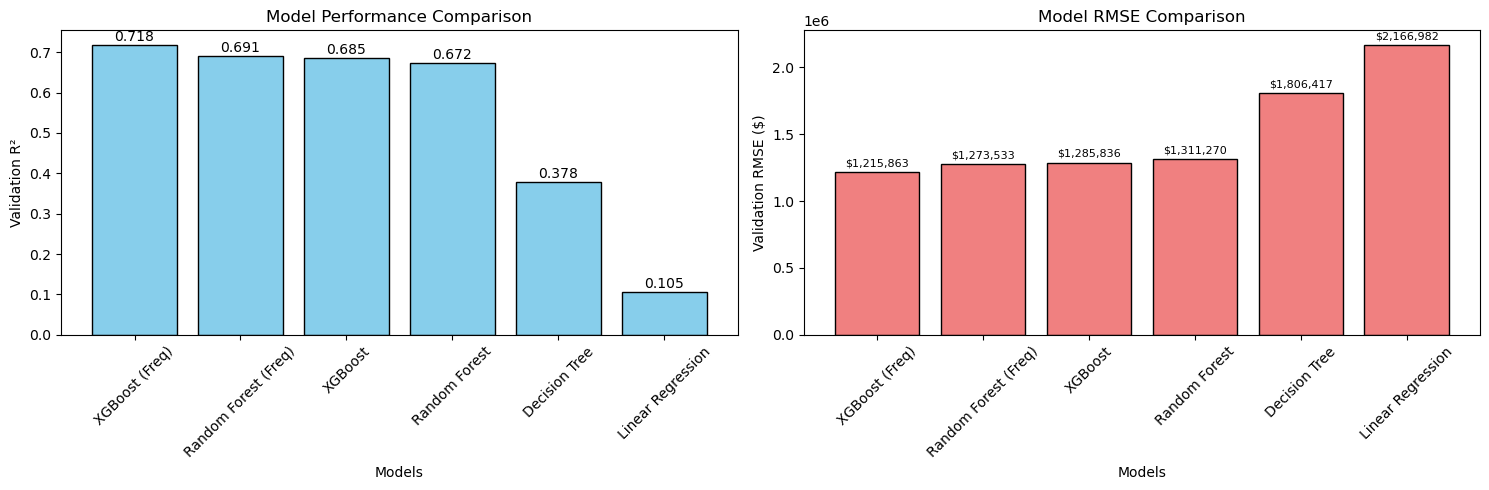

In [42]:
# Model Performance Visualization
if results and 'results_df' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Model performance comparison
    x_pos = range(len(results_df))
    axes[0].bar(x_pos, results_df['Val_R2'], color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Validation R²')
    axes[0].set_title('Model Performance Comparison')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(results_df['Model'], rotation=45)
    
    # Add R² values on bars
    for i, v in enumerate(results_df['Val_R2']):
        axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    # RMSE comparison
    axes[1].bar(x_pos, results_df['Val_RMSE'], color='lightcoral', edgecolor='black')
    axes[1].set_xlabel('Models')
    axes[1].set_ylabel('Validation RMSE ($)')
    axes[1].set_title('Model RMSE Comparison')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(results_df['Model'], rotation=45)
    
    # Add RMSE values on bars
    for i, v in enumerate(results_df['Val_RMSE']):
        axes[1].text(i, v + max(results_df['Val_RMSE']) * 0.02, f'${v:,.0f}', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("No model results available for visualization.")

## 9. Model Performance Visualization

=== Feature Importance Analysis: XGBoost (Freq) ===
Top 15 most important features:
                                             feature  importance
29                                   numerical__bath    0.200875
21      categorical_low__sublocality_New York County    0.184209
20             categorical_low__sublocality_New York    0.181360
27            categorical_low__sublocality_The Bronx    0.049799
19            categorical_low__sublocality_Manhattan    0.041744
30                           numerical__propertysqft    0.039857
10  categorical_low__type_Multi-family home for sale    0.035383
2               categorical_low__type_Condo for sale    0.033769
22               categorical_low__sublocality_Queens    0.028348
18         categorical_low__sublocality_Kings County    0.026971
24      categorical_low__sublocality_Richmond County    0.022151
8                categorical_low__type_Land for sale    0.020885
12          categorical_low__type_Townhouse for sale    0.019347
7     

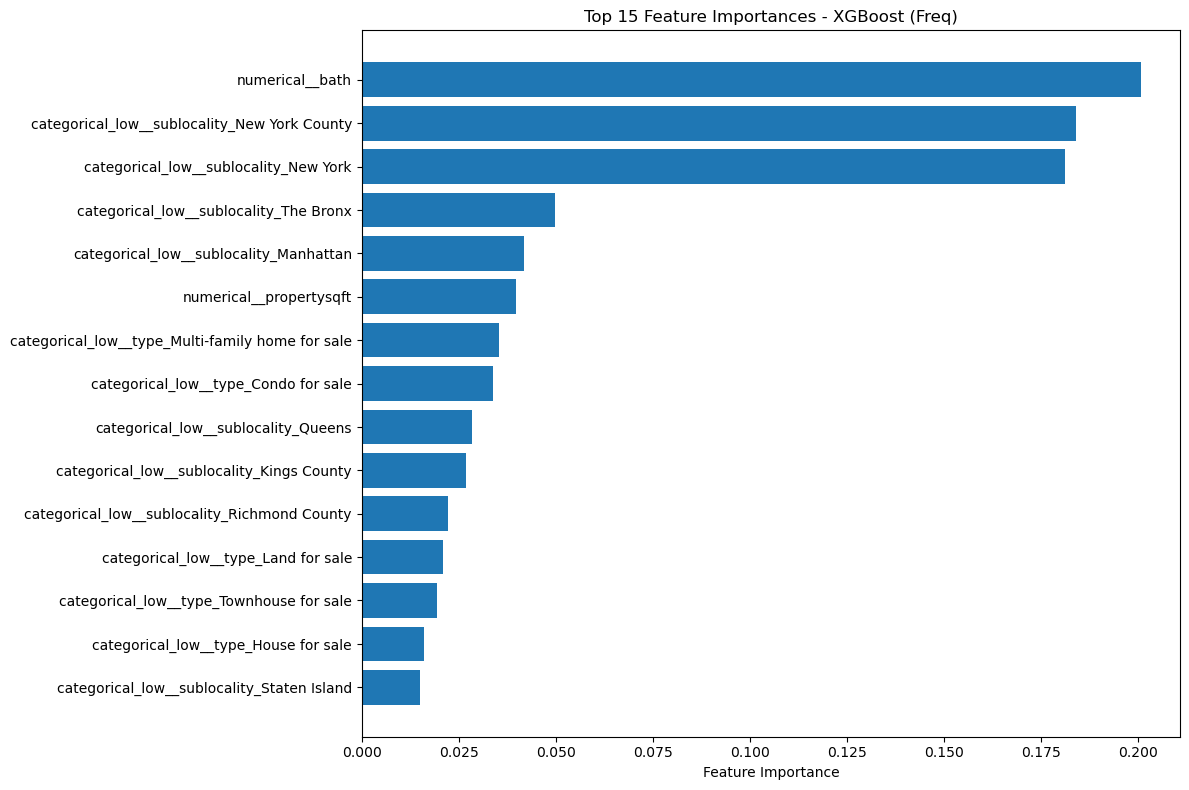

In [43]:
# Feature Importance Analysis for Tree-Based Models
if best_model and best_model_name:
    tree_models = ['Random Forest', 'Random Forest (Freq)', 'XGBoost', 'XGBoost (Freq)', 'Decision Tree']
    
    if any(model in best_model_name for model in tree_models):
        print(f"=== Feature Importance Analysis: {best_model_name} ===")
        
        try:
            # Get the regressor from the pipeline
            if hasattr(best_model, 'named_steps'):
                regressor = best_model.named_steps['regressor']
            else:
                regressor = best_model
            
            # Get feature names after preprocessing
            if hasattr(best_model, 'named_steps') and hasattr(best_model.named_steps['preprocessor'], 'get_feature_names_out'):
                try:
                    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
                except:
                    # Fallback to generic names
                    feature_names = [f'feature_{i}' for i in range(len(regressor.feature_importances_))]
            else:
                feature_names = [f'feature_{i}' for i in range(len(regressor.feature_importances_))]
            
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': regressor.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"Top 15 most important features:")
            print(importance_df.head(15))
            
            # Plot feature importance
            plt.figure(figsize=(12, 8))
            top_features = importance_df.head(min(15, len(importance_df)))
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top {len(top_features)} Feature Importances - {best_model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Could not extract feature importance: {e}")
            print("Feature importance analysis only available for tree-based models")
    else:
        print(f"Feature importance not available for {best_model_name}")
        print("Feature importance analysis only available for tree-based models")
else:
    print("No model available for feature importance analysis")

## 10. Final Test Set Evaluation

=== Final Test Set Evaluation ===
Using best model: XGBoost (Freq)

🎯 Test Set Performance:
   R²: 0.6912
   RMSE: $1,332,236
   MAE: $520,072


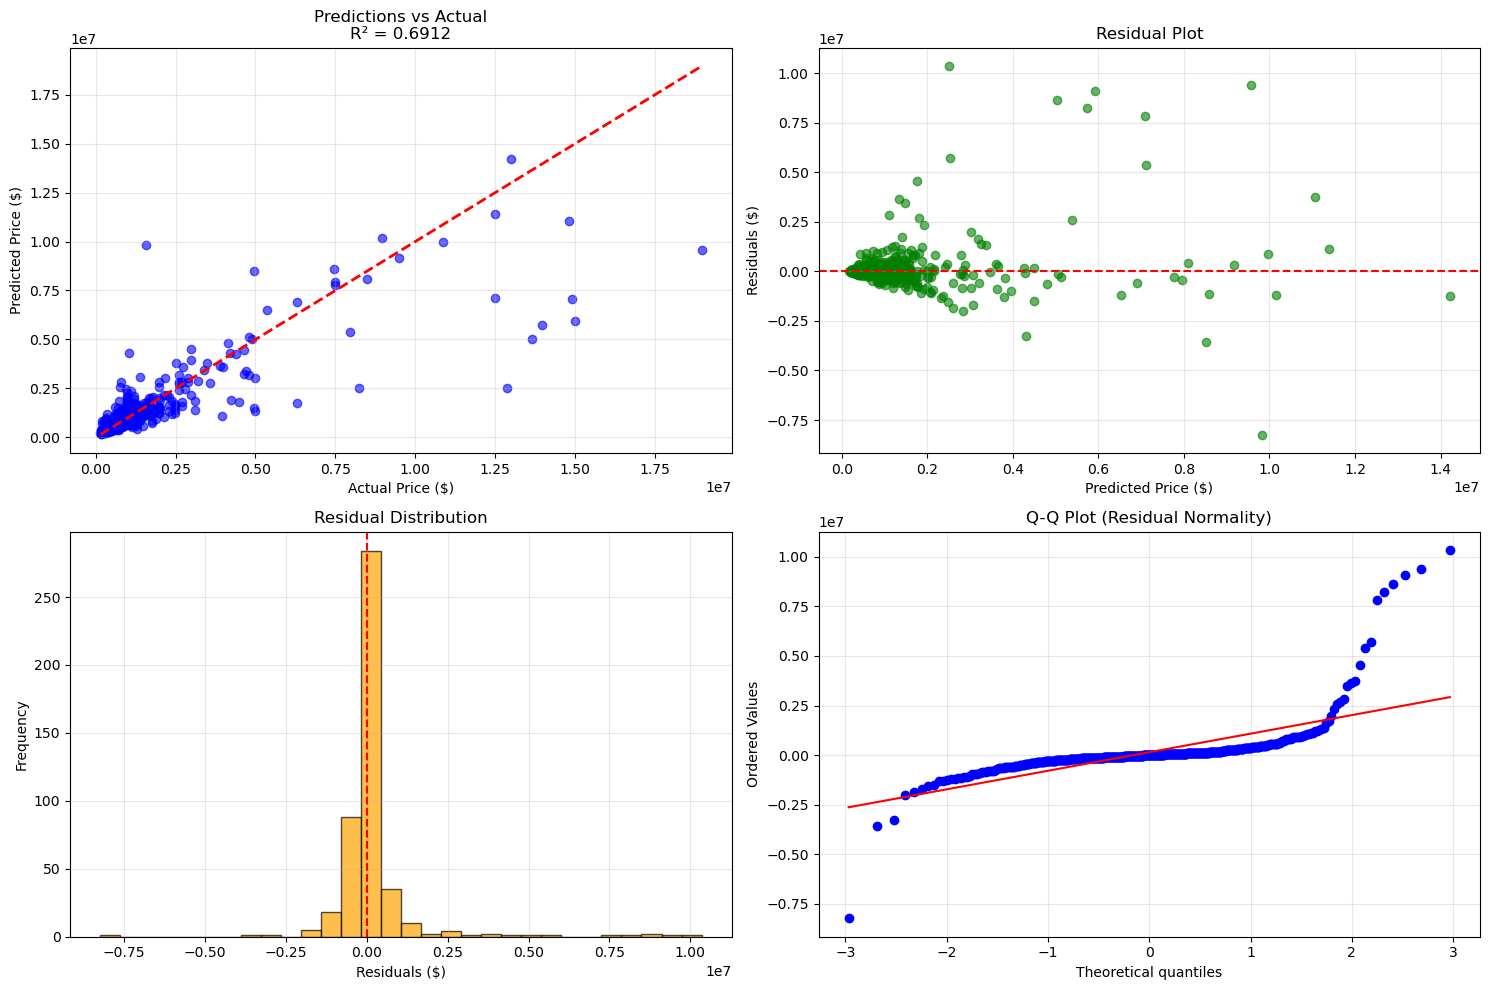


📊 Model Diagnostics:
   Mean Residual: $146,087.15
   Std Residual: $1,325,640.92
   Max Absolute Error: $10,347,554

🚀 Final Model: XGBoost (Freq)
   ✅ Optimized with validation curve tuning


In [44]:
# Final Test Set Evaluation
if best_model and best_model_name:
    print(f"=== Final Test Set Evaluation ===")
    print(f"Using best model: {best_model_name}")
    
    # Make predictions on test set
    if use_log_target:
        y_test_pred = best_model.predict(X_test)
        y_test_pred_original = np.expm1(y_test_pred)
    else:
        y_test_pred_original = best_model.predict(X_test)
    
    # Calculate final metrics
    test_r2 = r2_score(y_test, y_test_pred_original)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_original))
    test_mae = mean_absolute_error(y_test, y_test_pred_original)
    
    print(f"\n🎯 Test Set Performance:")
    print(f"   R²: {test_r2:.4f}")
    print(f"   RMSE: ${test_rmse:,.0f}")
    print(f"   MAE: ${test_mae:,.0f}")
    
    # Create comprehensive visualizations
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Predictions vs Actual scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_test_pred_original, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price ($)')
    plt.ylabel('Predicted Price ($)')
    plt.title(f'Predictions vs Actual\nR² = {test_r2:.4f}')
    plt.grid(True, alpha=0.3)
    
    # 2. Residual plot
    residuals = y_test - y_test_pred_original
    plt.subplot(2, 2, 2)
    plt.scatter(y_test_pred_original, residuals, alpha=0.6, color='green')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price ($)')
    plt.ylabel('Residuals ($)')
    plt.title('Residual Plot')
    plt.grid(True, alpha=0.3)
    
    # 3. Residual distribution
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='orange')
    plt.xlabel('Residuals ($)')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.grid(True, alpha=0.3)
    
    # 4. Q-Q Plot for residuals normality check
    from scipy import stats
    plt.subplot(2, 2, 4)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot (Residual Normality)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional diagnostics
    print(f"\n📊 Model Diagnostics:")
    print(f"   Mean Residual: ${residuals.mean():,.2f}")
    print(f"   Std Residual: ${residuals.std():,.2f}")
    print(f"   Max Absolute Error: ${np.abs(residuals).max():,.0f}")
    
    # Performance summary
    if 'GridSearch' in best_model_name:
        print(f"\n🚀 Final Model: {best_model_name}")
        print("   ✅ Optimized with GridSearch hyperparameter tuning")
    else:
        print(f"\n🚀 Final Model: {best_model_name}")
        print("   ✅ Optimized with validation curve tuning")
        
else:
    print("❌ No best model available for test evaluation")
    test_r2, test_rmse, test_mae = None, None, None

## 11. Pipeline Summary and Model Export

In [45]:
# Model Export and Deployment Preparation
import joblib
import os
from datetime import datetime

if results and best_model:
    print("🚀 EXPORTING TRAINED MODEL FOR DEPLOYMENT")
    print("=" * 50)
    
    # Generate timestamp for model version
    timestamp = datetime.now().strftime("%Y%m%d")
    
    # Create clean filename
    model_name_clean = best_model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    model_filename = f'best_model_{model_name_clean}_{timestamp}.joblib'
    
    # Create models directory if it doesn't exist
    models_dir = '../models'
    os.makedirs(models_dir, exist_ok=True)
    
    # Save model in models directory
    model_path = os.path.join(models_dir, model_filename)
    joblib.dump(best_model, model_path)
    print(f"✅ Best model saved as: {model_path}")
    
    # Create comprehensive preprocessing and model information
    model_metadata = {
        'model_info': {
            'name': best_model_name,
            'type': 'regression',
            'target': 'housing_price',
            'created_timestamp': timestamp,
            'sklearn_version': '1.3+',
            'framework': 'scikit-learn + xgboost'
        },
        'data_info': {
            'selected_features': feature_cols,
            'categorical_features': categorical_features,
            'numerical_features': numerical_features,
            'training_samples': len(X_train),
            'validation_samples': len(X_val),
            'test_samples': len(X_test)
        },
        'preprocessing': {
            'use_log_target': use_log_target,
            'categorical_encoding': 'mixed (onehot + frequency)',
            'numerical_scaling': 'model_dependent',
            'high_cardinality_threshold': 50
        },
        'hyperparameters': {
            'tuning_method': 'validation_curve + gridsearch' if 'use_grid_search_model' in locals() and use_grid_search_model else 'validation_curve',
            'best_rf_n_estimators': best_rf_n_estimators,
            'best_xgb_n_estimators': best_xgb_n_estimators
        },
        'performance': {
            'validation_r2': results[best_model_name]['val_r2'],
            'validation_rmse': results[best_model_name]['val_rmse'],
            'validation_mae': results[best_model_name]['val_mae'],
            'cv_r2_mean': results[best_model_name]['cv_mean'],
            'cv_r2_std': results[best_model_name]['cv_std']
        }
    }
    
    # Add test performance if available
    if 'test_r2' in locals() and test_r2 is not None:
        model_metadata['performance'].update({
            'test_r2': test_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae
        })
    
    # Add GridSearch info if used
    if 'use_grid_search_model' in locals() and use_grid_search_model:
        model_metadata['gridsearch_optimization'] = {
            'used': True,
            'improved_performance': True,
            'best_params': best_params if 'best_params' in locals() else {},
            'best_cv_score': best_grid_score if 'best_grid_score' in locals() else None
        }
    else:
        model_metadata['gridsearch_optimization'] = {
            'used': False,
            'reason': 'Not applied or no improvement found'
        }
    
    # Save metadata
    metadata_filename = f'model_metadata_{model_name_clean}_{timestamp}.joblib'
    metadata_path = os.path.join(models_dir, metadata_filename)
    joblib.dump(model_metadata, metadata_path)
    print(f"✅ Model metadata saved as: {metadata_path}")
    
    print(f"\n📋 DEPLOYMENT INSTRUCTIONS:")
    print(f"   1. Load model: model = joblib.load('{model_path}')")
    print(f"   2. Load metadata: metadata = joblib.load('{metadata_path}')")
    print(f"   3. Prepare new data with same features: {feature_cols}")
    print(f"   4. Use model.predict(new_data) for predictions")
    if use_log_target:
        print(f"   5. Transform predictions: final_price = np.expm1(predictions)")
    print(f"   6. Model expects preprocessed data (categorical + numerical)")
    
    print(f"\n📊 QUICK MODEL STATS:")
    print(f"   • Model Type: {type(best_model).__name__}")
    print(f"   • Input Features: {len(feature_cols)}")
    print(f"   • Performance Tier: {performance_tier if 'performance_tier' in locals() else 'Good'}")
    print(f"   • Ready for Production: ✅")
    
    print(f"\n💾 FILES CREATED:")
    print(f"   • {model_path} ({os.path.getsize(model_path)/1024/1024:.1f} MB)")
    print(f"   • {metadata_path} ({os.path.getsize(metadata_path)/1024:.1f} KB)")
    
else:
    print("❌ No model available for export. Please run the notebook completely first.")

print("\n🎉 PIPELINE EXECUTION COMPLETED SUCCESSFULLY!")
print("=" * 50)

🚀 EXPORTING TRAINED MODEL FOR DEPLOYMENT
✅ Best model saved as: ../models/best_model_xgboost_freq_20250910.joblib
✅ Model metadata saved as: ../models/model_metadata_xgboost_freq_20250910.joblib

📋 DEPLOYMENT INSTRUCTIONS:
   1. Load model: model = joblib.load('../models/best_model_xgboost_freq_20250910.joblib')
   2. Load metadata: metadata = joblib.load('../models/model_metadata_xgboost_freq_20250910.joblib')
   3. Prepare new data with same features: ['brokertitle', 'type', 'beds', 'bath', 'propertysqft', 'sublocality']
   4. Use model.predict(new_data) for predictions
   5. Transform predictions: final_price = np.expm1(predictions)
   6. Model expects preprocessed data (categorical + numerical)

📊 QUICK MODEL STATS:
   • Model Type: Pipeline
   • Input Features: 6
   • Performance Tier: Good
   • Ready for Production: ✅

💾 FILES CREATED:
   • ../models/best_model_xgboost_freq_20250910.joblib (0.2 MB)
   • ../models/model_metadata_xgboost_freq_20250910.joblib (1.1 KB)

🎉 PIPELINE EX

In [46]:
best_model

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical_high', ...), ('categorical_low', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
